In [3]:
# Import libraries
import os
import gc
import time
import math
import datetime

import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Load sales, prices and calendar data

In [4]:
print("Load Data")
sales = pd.read_csv("sales_train_validation.csv")
prices = pd.read_csv("sell_prices.csv")
calendar = pd.read_csv("calendar.csv")

Load Data


In [3]:
# Quick look at each dataset
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [5]:
sales['item_id'].nunique()

3049

In [4]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [5]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


# EDA

### Initial time series plot on state level

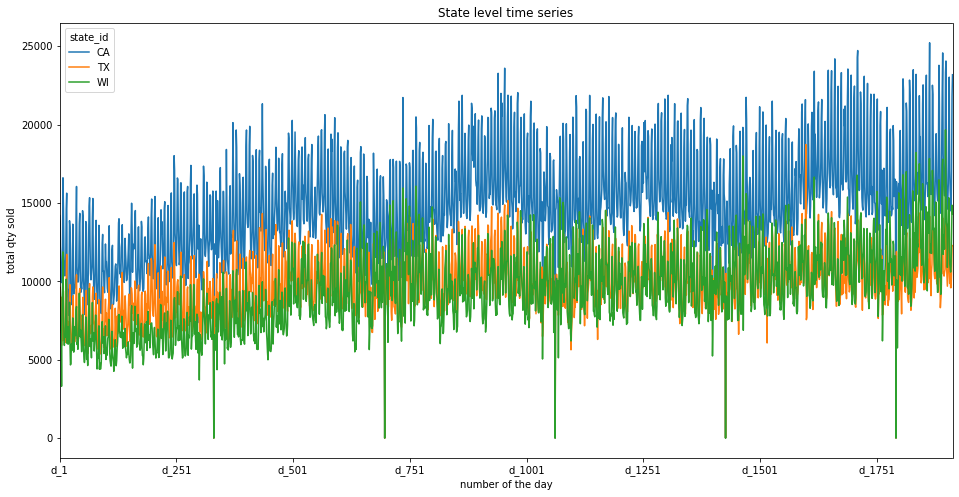

In [6]:
state_sum = sales.groupby(["state_id"]).sum().T # group total quantity sold by state

title = "State level time series"
xlabel = "number of the day"
ylabel = "total qty sold"
state_plot = state_sum.plot(figsize=(16,8), title = title)
state_plot.set(xlabel = xlabel, ylabel = ylabel)

plt.show()

We can see that CA has highest sales. Sales for TX and WI are not that different comparing to CA.

### Initial time series plot on category level

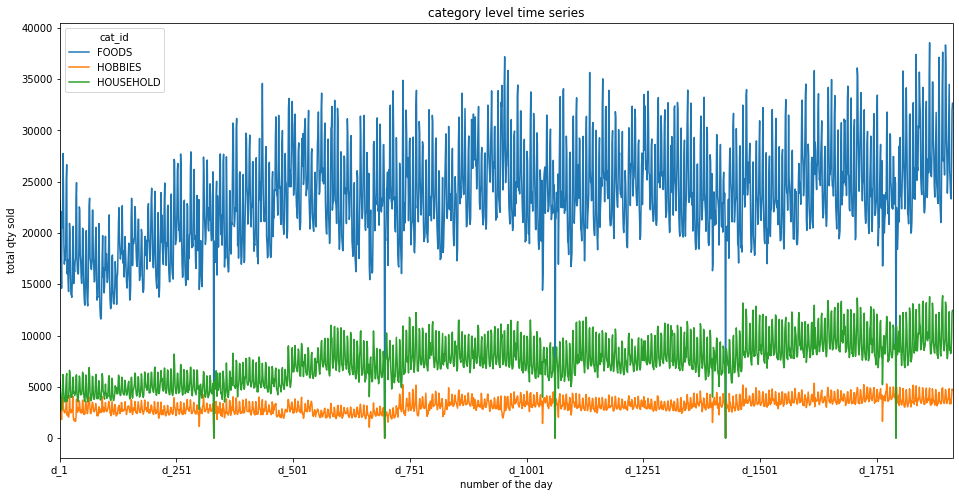

In [7]:
cat_sum = sales.groupby(["cat_id"]).sum().T # group total quantity sold by category

title = "category level time series"
xlabel = "number of the day"
ylabel = "total qty sold"
cat_plot = cat_sum.plot(figsize=(16,8), title = title)
cat_plot.set(xlabel = xlabel, ylabel = ylabel)

plt.show()

 We can see that foods category has the highest sales and hobbies has the lowest sales.

### Total Sales and mean sales for each store

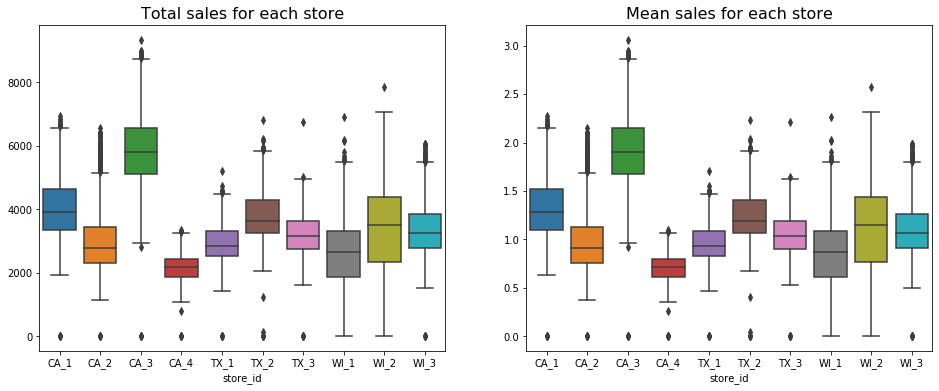

In [8]:
store_sum = sales.groupby(["store_id"]).sum().T.reset_index(drop=True)
store_mean = sales.groupby(["store_id"]).mean().T.reset_index(drop=True)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.boxplot(data = store_sum, ax=ax[0])
ax[0].set_title("Total sales for each store", fontsize=16)
sns.boxplot(data = store_mean, ax=ax[1])
ax[1].set_title("Mean sales for each store", fontsize=16)

plt.show()

 We can see that sales for different stores are pretty different. Since the data is so large, we can consider
 to train the model separately for each store.

### Seasonal Decomposition for trends and seasonality

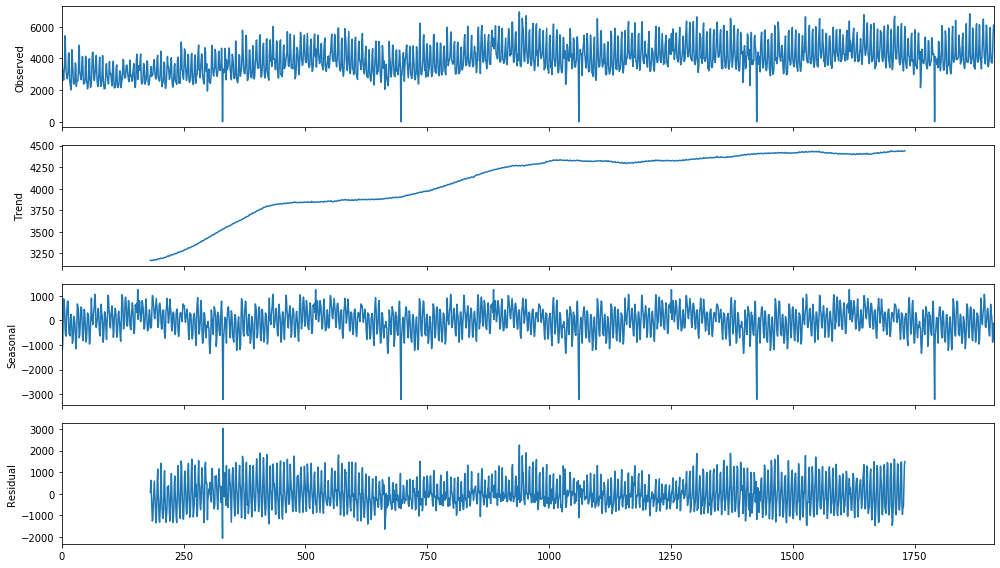

In [9]:
# yealy cycle decompose of CA_1 Store
from statsmodels.tsa.seasonal import seasonal_decompose

CA1_sales = store_sum["CA_1"]
CA1_year = seasonal_decompose(CA1_sales, freq=365)

from pylab import rcParams
rcParams["figure.figsize"] = 14,8
CA1_year.plot()

plt.show()

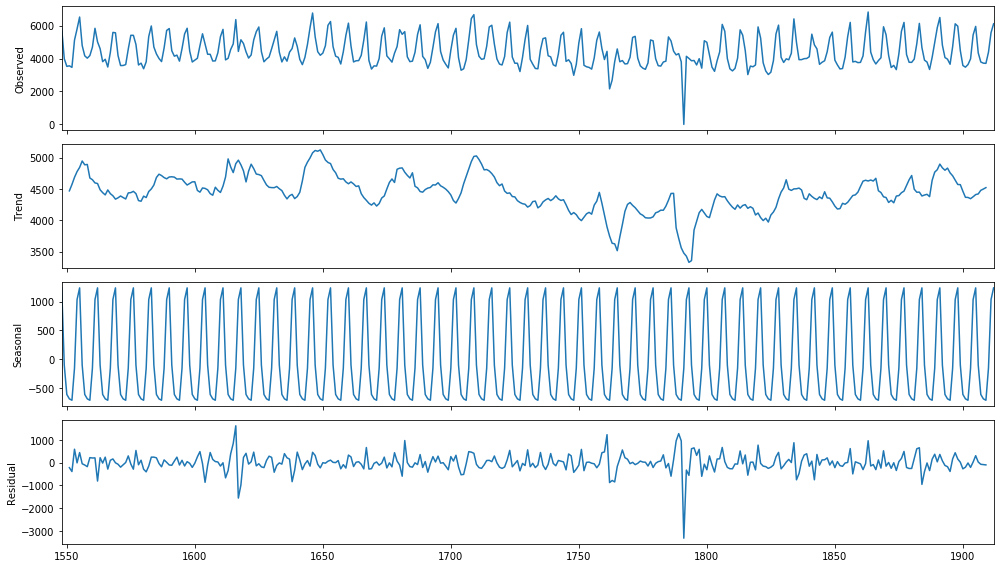

In [10]:
# weekly cycle decompose of CA_1 Store
from statsmodels.tsa.seasonal import seasonal_decompose

CA1_sales = store_sum["CA_1"][1913-365:] # only look at the most recent 1 year data
CA1_year = seasonal_decompose(CA1_sales, freq=7)

from pylab import rcParams
rcParams["figure.figsize"] = 14,8
CA1_year.plot()

plt.show()

Weekly seasonality is pretty strong.

### Would events and snap days affect sales?

In [11]:
# merge sales data with calendar data
sales_df = sales.groupby(["store_id"]).sum().T
cal = calendar[["date", "d", "event_name_1", "event_type_1", 
                "snap_CA", "snap_TX", "snap_WI"]].set_index("d").iloc[:1913] 
# we only need these columns, since only 5 days have two events and we can safely ingore them

sales_cal = sales_df.join(cal) # merge the two datasets together
sales_cal["date"] = pd.to_datetime(sales_cal["date"])
sales_cal = sales_cal.set_index("date")
del cal

sales_cal.head()

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI
date,,,,,,,,,,,,,,,
2011-01-29,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038,NaN,NaN,0,0,0
2011-01-30,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198,NaN,NaN,0,0,0
2011-01-31,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317,NaN,NaN,0,0,0
2011-02-01,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211,NaN,NaN,1,1,0
2011-02-02,2630,1942,3817,1536,1694,2492,1726,2,1175,2132,NaN,NaN,1,0,1


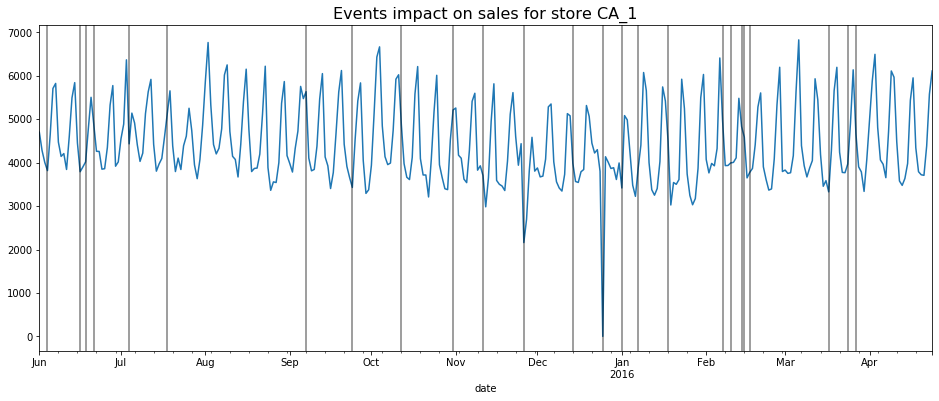

In [12]:
# Check the impact of events for the recent one year sales for store CA_1 as an example
ax = sales_cal["CA_1"].iloc[1584:].plot(figsize=(16,6))

for day in sales_cal[sales_cal.event_name_1.notnull()].index:
    ax.axvline(x=day, color="black", alpha=0.5)

ax.set_title("Events impact on sales for store CA_1", fontsize=16)
plt.show()

Seems like usually events dont have that big impact on sales, only on Christmas because the store closes.

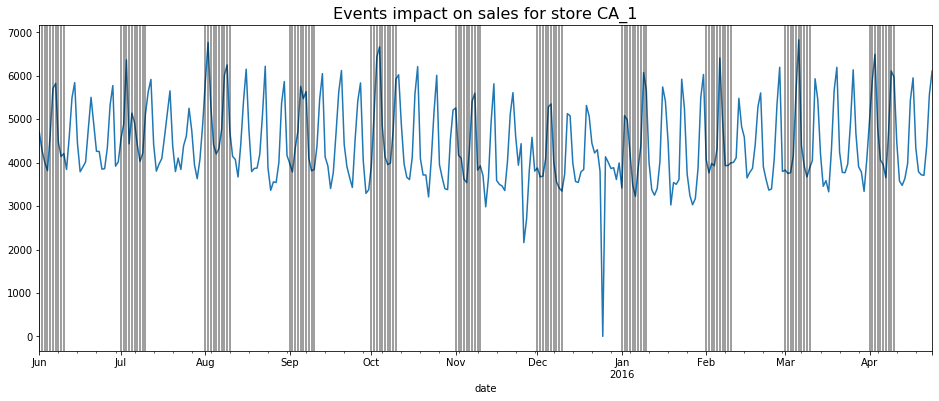

In [13]:
# Check the impact of SNAP (food stamps) for the recent one year sales for store CA_1 as an exmaple
ax = sales_cal["CA_1"].iloc[1584:].plot(figsize=(16,6))

for day in sales_cal[sales_cal.snap_CA == 1].index:
    ax.axvline(x=day, color="black", alpha=0.5)

ax.set_title("Events impact on sales for store CA_1", fontsize=16)
plt.show()

 Seems like SNAP has positive impact on sales.

## Baseline SARIMA model

We can try SARIMA model first for different stores. Here is an example for CA_1 and we can fit SARIMA for other stores as well.

In [24]:
# SARIMA for store CA_1
# Set the last 28 days to be test data, and the remaining to be training data

train_CA1 = sales_cal["CA_1"].iloc[:1885]
test_CA1 = sales_cal["CA_1"].iloc[1886:]

# Select the optimal parameters for SARIMA based on AIC and BIC
from pmdarima import auto_arima
auto_arima(sales_cal["CA_1"], seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1913
Model:             SARIMAX(3, 1, 1)x(2, 0, 1, 7)   Log Likelihood              -14351.805
Date:                           Mon, 24 Aug 2020   AIC                          28721.611
Time:                                   20:57:03   BIC                          28771.614
Sample:                                        0   HQIC                         28740.013
                                          - 1913                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.001     -0.218      0.827      -0.002       0.002
ar.L1          0.3772      0.017     21.692      0.000       0.343       0.411
ar.L2          0.0373      0.020      1.840      0.066      -0.002       0.077
ar.L3         -0.0248      0.024     -1.040      0.298      -0.071       0.022
ma.L1         -0.9439      0.015    -64.571      0.000      -0.973      -0.915
ar.S.L7        1.1072      0.022     49.583      0.000       1.063       1.151
ar.S.L14      -0.1072      0.022     -4.801      0.000      -0.151      -0.063
ma.S.L7       -0.9340      0.011    -88.583      0.000      -0.955      -0.913
sigma2      1.871e+05   7.16e-08   2.61e+12      0.000    1.87e+05    1.87e+05
===================================================================================
Ljung-Box (Q):                      172.82   Jarque-Bera (JB):             17522.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+27. Standard errors may be unstable.
"""

In [45]:
# From the above result, we are going to fit SARIMAX(3, 1, 1)x(2, 0, 1, 7) to the training data
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_CA1 = SARIMAX(train_CA1, order=(3,1,1), seasonal_order=(2,0,1,7),
                    enforce_invertibility=False)

result_CA1 = model_CA1.fit()
result_CA1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                              CA_1   No. Observations:                 1885
Model:             SARIMAX(3, 1, 1)x(2, 0, 1, 7)   Log Likelihood              -14567.911
Date:                           Mon, 24 Aug 2020   AIC                          29151.822
Time:                                   21:58:56   BIC                          29196.151
Sample:                               01-29-2011   HQIC                         29168.148
                                    - 03-27-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3326      0.047      7.061      0.000       0.240       0.425
ar.L2          0.0585      0.054      1.091      0.275      -0.047       0.163
ar.L3          0.0594      0.067      0.890      0.373      -0.071       0.190
ma.L1         -0.9674      0.019    -50.172      0.000      -1.005      -0.930
ar.S.L7        1.0246      0.056     18.418      0.000       0.916       1.134
ar.S.L14      -0.0246      0.056     -0.443      0.658      -0.134       0.084
ma.S.L7       -0.9972      0.015    -64.811      0.000      -1.027      -0.967
sigma2      5.816e+05   7.18e-08    8.1e+12      0.000    5.82e+05    5.82e+05
===================================================================================
Ljung-Box (Q):                      364.07   Jarque-Bera (JB):             18841.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -1.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.58e+27. Standard errors may be unstable.
"""

In [46]:
# Make predictions
start = len(train_CA1)
end = len(train_CA1) + len(test_CA1) - 1

CA1_predictions = result_CA1.predict(start, end).rename("SARIMA Model for CA_1")

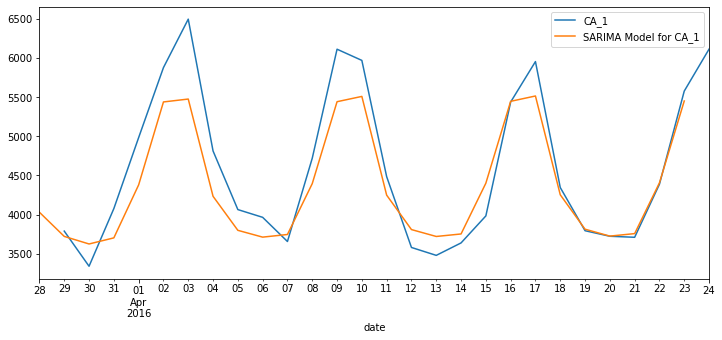

In [47]:
# Plot the predictions
test_CA1.plot(legend=True, figsize=(12,5))
CA1_predictions.plot(legend=True)

plt.show()

 Seems like the model did not do well on capturing the peak.

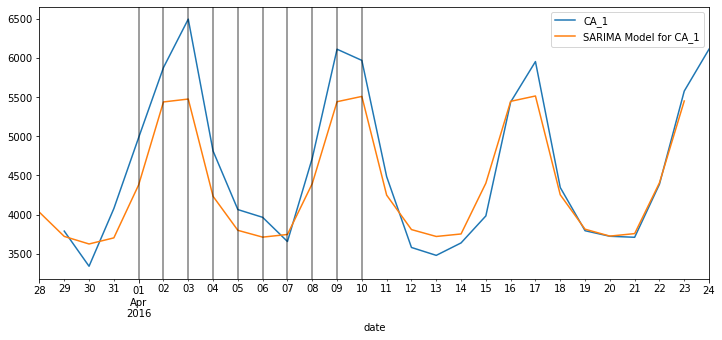

In [48]:
# We can see if SNAP has an impact on these peak sales
ax = test_CA1.plot(legend=True, figsize=(12,5))
CA1_predictions.plot(legend=True)

for day in sales_cal[sales_cal.snap_CA == 1].index:
    ax.axvline(x=day, color="black", alpha=0.5)

In [49]:
# Calculate RMSE for the model
from statsmodels.tools.eval_measures import rmse
print("RMSE for SARIMA model is {}".format(rmse(test_CA1, CA1_predictions)))

RMSE for SARIMA model is 790.842761770512


## Baseline SARIMAX model

Since snap seems to be an exogenous regressor for sales, we can try SARIMAX to see if it improves the prediction or not. From my experience, usually XGBoost and LightGBM would have better performance, but it's good to use it as a baseline model.

In [30]:
# SARIMAX for store CA_1

# Select the optimal parameters for SARIMAX based on AIC and BIC
auto_arima(sales_cal["CA_1"], exogenous=sales_cal[["snap_CA"]], seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1913
Model:             SARIMAX(3, 1, 2)x(1, 0, 1, 7)   Log Likelihood              -14232.295
Date:                           Mon, 24 Aug 2020   AIC                          28484.591
Time:                                   21:41:04   BIC                          28540.150
Sample:                                        0   HQIC                         28505.037
                                          - 1913                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.003     -0.047      0.962      -0.006       0.006
x1           296.4289     24.893     11.908      0.000     247.640     345.217
ar.L1         -0.7637      0.016    -47.554      0.000      -0.795      -0.732
ar.L2          0.1772      0.025      7.011      0.000       0.128       0.227
ar.L3         -0.0579      0.018     -3.163      0.002      -0.094      -0.022
ma.L1          0.0527      0.011      4.867      0.000       0.032       0.074
ma.L2         -0.9384      0.011    -84.640      0.000      -0.960      -0.917
ar.S.L7        0.9999   4.41e-05   2.27e+04      0.000       1.000       1.000
ma.S.L7       -0.9751      0.005   -185.951      0.000      -0.985      -0.965
sigma2      1.709e+05      0.060   2.83e+06      0.000    1.71e+05    1.71e+05
===================================================================================
Ljung-Box (Q):                      149.68   Jarque-Bera (JB):             25027.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -1.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.59e+22. Standard errors may be unstable.
"""

In [32]:
# From the above result, we are going to fit SARIMAX(3, 1, 2)x(1, 0, 1, 7) to the training data
model_CA1 = SARIMAX(train_CA1, exog=sales_cal[["snap_CA"]].iloc[:1885], order=(3,1,2), seasonal_order=(1,0,1,7),
                    enforce_invertibility=False)

result_CA1 = model_CA1.fit()
result_CA1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                              CA_1   No. Observations:                 1885
Model:             SARIMAX(3, 1, 2)x(1, 0, 1, 7)   Log Likelihood              -14040.256
Date:                           Mon, 24 Aug 2020   AIC                          28098.512
Time:                                   21:46:50   BIC                          28148.382
Sample:                               01-29-2011   HQIC                         28116.878
                                    - 03-27-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
snap_CA      284.8081     26.087     10.918      0.000     233.679     335.937
ar.L1         -0.7447      0.016    -45.732      0.000      -0.777      -0.713
ar.L2          0.1663      0.025      6.552      0.000       0.117       0.216
ar.L3         -0.0860      0.019     -4.620      0.000      -0.122      -0.050
ma.L1          0.0614      0.017      3.680      0.000       0.029       0.094
ma.L2         -0.9440      0.011    -85.669      0.000      -0.966      -0.922
ar.S.L7        1.0000   2.07e-05   4.83e+04      0.000       1.000       1.000
ma.S.L7       -1.0350      0.007   -146.118      0.000      -1.049      -1.021
sigma2      1.624e+05      0.005   3.01e+07      0.000    1.62e+05    1.62e+05
===================================================================================
Ljung-Box (Q):                      131.67   Jarque-Bera (JB):             22326.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                            -1.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.74e+23. Standard errors may be unstable.
"""

In [33]:
# Make predictions
start = len(train_CA1)
end = len(train_CA1) + len(test_CA1) - 1

CA1_predictions = result_CA1.predict(start, end, 
                                     exog=sales_cal[["snap_CA"]].iloc[1886:]).rename("SARIMAX Model for CA_1")

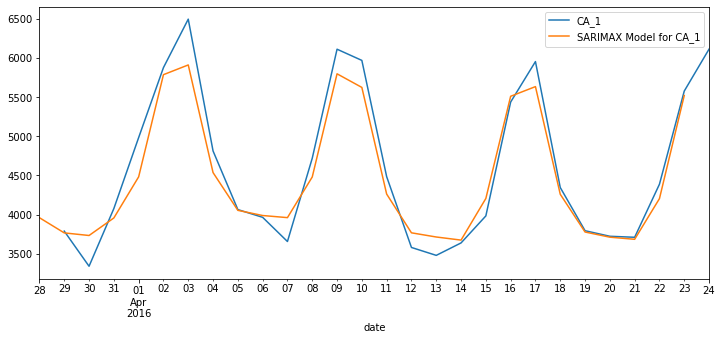

In [34]:
# Plot the predictions
test_CA1.plot(legend=True, figsize=(12,5))
CA1_predictions.plot(legend=True)

plt.show()

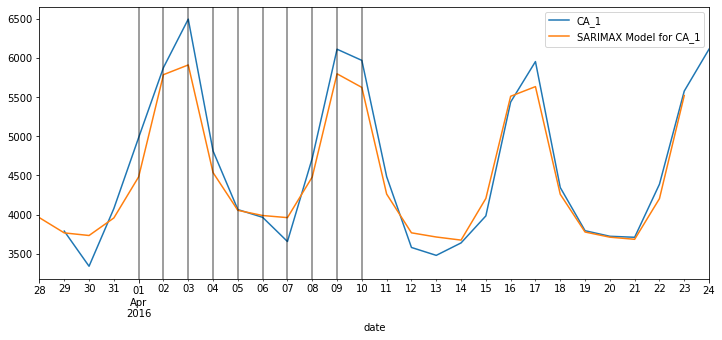

In [35]:
# We can see if SNAP has an impact on these peak sales
ax = test_CA1.plot(legend=True, figsize=(12,5))
CA1_predictions.plot(legend=True)

for day in sales_cal[sales_cal.snap_CA == 1].index:
    ax.axvline(x=day, color="black", alpha=0.5)

In [42]:
# Calculate RMSE for the model
from statsmodels.tools.eval_measures import rmse
print("RMSE for SARIMAX model is {}".format(rmse(test_CA1, CA1_predictions),4))

RMSE for SARIMAX model is 791.9218363424241


 Seems like SARIMAX is doing better on capture the peaks but overall not significantly better than SARIMA for
 store CA_1. We can fit these two models for each store and use the best model to predict sales for each product.